In [1]:
%load_ext autotime

In [2]:
import numpy as np
import os
import matplotlib.pylab as plt

time: 2.49 s


In [31]:
file = "DC-Netzteil-positiv.bin"
file2 = "DC-Netzteil-negativ.bin"

time: 1.99 ms


In [6]:
def read_data(sensor, start, stop, filename):
    with open(filename, 'rb') as f:
        if sensor < 1 or sensor > 8:
            print('Sensor must be between 1 and 8')
            return
        sensor -= 1 # actully sensors are [0..7]
        # get file size
        f.seek(0, os.SEEK_END)
        size = f.tell() # size in byte
        total_value_count = (size/4) * 2

        # if the files contains not enough data it is pointless
        if total_value_count < 16:
            print('The measurement file is garbage.')
            return

        # find sensor in data and count active sensors
        f.seek(0)
        data = f.read(32) # read first 8 32 bit values
        sensors = 8 * [0]
        for i in range(8):
            index = i * 4
            value = int.from_bytes(data[index:index+4], "little")
            sensors[i] = value >> 28
        sensor_index = -1
        first_sensor = -1
        active_sensor_count = 0
        for i, value in enumerate(sensors):
            if i == 0:
                first_sensor = value
            elif value == first_sensor:
                active_sensor_count = i
                break
            if value == sensor:
                sensor_index = i
        if sensor_index == -1:
            print('sensor not within data')
            return
        if active_sensor_count == 0: # all 8 sensors active
            active_sensor_count = 8

        # correct value count according to sensors count
        total_value_count /= active_sensor_count
        
        # seek distance
        seek_distance = 4 * active_sensor_count
        
        # clamp start and stop
        if start == 0 and stop == 0:
            stop = total_value_count - 1
        else:
            if start < 0:
                start = 0
            elif start >= total_value_count - 1:
                start = total_value_count - 2
            if stop < 1:
                stop = 1
            elif stop >= total_value_count:
                stop = total_value_count - 1
            if start >= stop:
                stop = start + 1
        step_size = 1
        if stop - start > 2000:
            step_size = int((stop-start) / 2000)
        x_array = np.arange(start, stop, step_size)
        y_array = np.empty(len(x_array), dtype=np.float64)
        data_pos = start
        index = 0
        while index < len(x_array):
            f.seek((data_pos >> 1)*seek_distance + sensor_index * 4) # data_pos / 2 because 2 values are within 32 bit value
            data = f.read(4)
            value = int.from_bytes(data, "little")
            sensornum, value1, value2 = value >> 28, (value >> 14) & 0b11111111111111, value & 0b11111111111111
            if data_pos % 2 == 0:
                y_array[index] = (value1 / 0b11111111111111) * 2 - 1
                index += 1
                if index >= len(x_array):
                    break
                if step_size == 1:
                    y_array[index] = (value2 / 0b11111111111111) * 2 - 1
                    index += 1
                    data_pos += 2
                else:
                    data_pos += step_size
            else:
                y_array[index] = (value2 / 0b11111111111111) * 2 - 1
                index += 1
                data_pos += step_size
        return {'start': start, 'stop': stop-1, 'x': x_array, 'y': y_array}

def plot_data(values):
    #with plt.xkcd(): # comic style
        x_vals = None
        y_vals = None
        plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.xlabel('t in s * 10^-7')
        plt.ylabel('U in V')
        plt.xlim(values['start'], values['stop'])
        plt.plot(values['x'], values['y'])

time: 46.7 ms


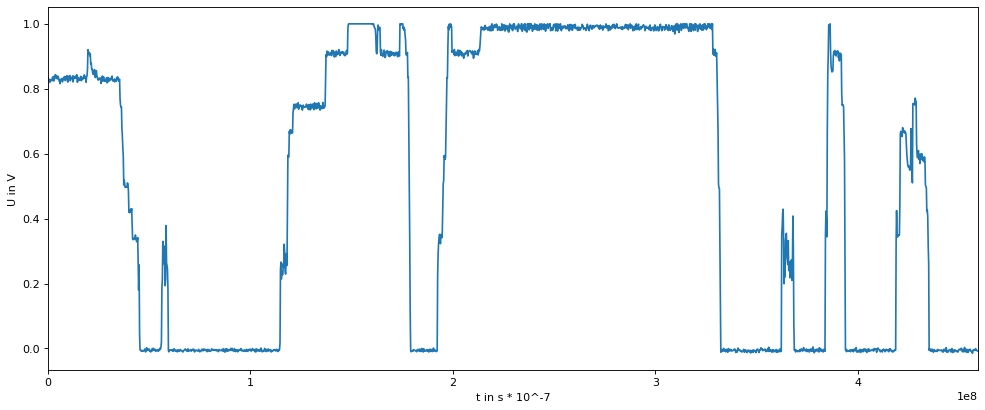

time: 414 ms


In [32]:
data = read_data(1, 0, 0, file)
if data:
    plot_data(data)

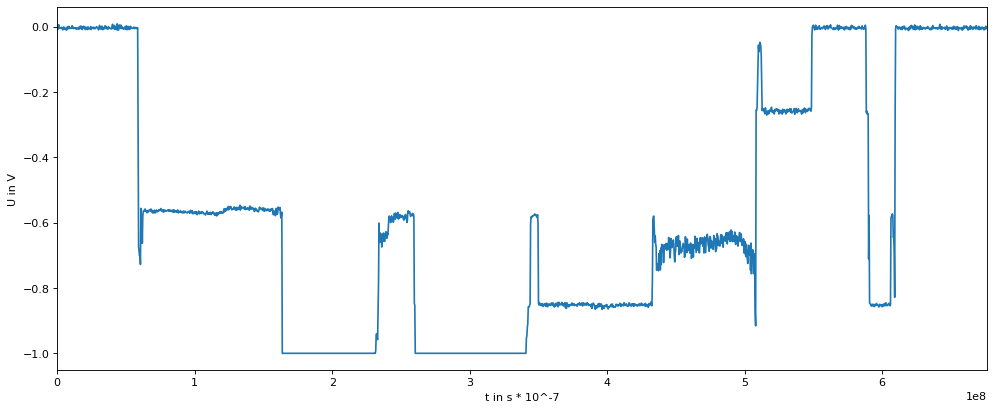

time: 430 ms


In [33]:
data = read_data(1, 0, 0, file2)
if data:
    plot_data(data)